# Exercise Sheet 6

Homework by: Jakob Kreft and Lukas Matt

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse
from sklearn.linear_model import Ridge, Lasso, LinearRegression

## 1 Regularization and Bias

$$ y = \beta_0 + \beta^T x + \epsilon = \tilde\beta^T\tilde x + \varepsilon $$

Consider a regression problem with two explanatory variables $x_1, x_2$, i.e. $\beta = (\beta_0 , \beta_1 , \beta_2 )^T$ and $x = (1, x_0 , x_1 )^T$.

### (a)
In this setting, write down the loss function for ridge regression, penalizing the L2 -norm of $β$, in
components. What is the influence of the regression strength on the bias $β_0$?

$$ y = (y_1, y_2, y_3) \in \mathbb{R}^3 $$

$$ \mathrm{Loss} = \| y - \beta^T x \|^2 + \lambda \| \beta \|^2 $$

$$ = \| y - \beta^T x \|^2 + \lambda ( \beta_0^2 + \beta_1^2 + \beta_2^2) $$

$$ = \| y - \beta^T x \|^2 + \lambda(\beta_1^2 + \beta_2^2) + \lambda \beta_0^2$$


The regularization strengt $\lambda$ is a factor in front of $\beta_0^2$. If the regularization is strong, high values of $\beta_0$ are penalized (the same is true for all $\beta_i$).

### (b)
Oftentimes, a regularization of the bias term is unwanted. How would you modify the loss function to
account for this?

Somehow, $\beta_0$ needs to be removed / the factor set to $=0$. This can be achieved for example by dealing with $\beta_0$ separately:

$$ y = \beta_0 + \beta^T x + \varepsilon $$

where now $\beta = (\beta_1 , \beta_2 )^T$ and $x = (x_0 , x_1 )^T$.

The new loss function is:

$$ \mathrm{Loss}_\mathrm{bias} = \| y - \beta^T x - \beta_0 \|^2 + \lambda \| \beta \|^2 $$

Alternatively, one might instead introduce the regression strength as a vector quantity $\vec\lambda = (\lambda_i)_i^T$ wich allows to set the regularization strength indiviually for each parameter $\beta_i$. The new loss would be:

$$ \mathrm{Loss}_\mathrm{vect} = \| y - \beta^T x - \beta_0 \|^2 + (\vec\lambda \circ \beta)^T\beta $$

where $a\circ b$ is the Hadamard product (element-wise multiplication) of two vectors $a$ and $b$.

Setting $\lambda_0 = 0$ and $\lambda_1 = \lambda_2 = \lambda$ in the example at hand yields:

$$ \mathrm{Loss}_\mathrm{vect} = \| y - \beta^T x \|^2 + 
\begin{pmatrix}\lambda_0 \beta_0 \\ \lambda_1\beta_1 \\ \lambda_2\beta_2\end{pmatrix}^T \cdot
\begin{pmatrix}\beta_0 \\ \beta_1 \\\beta_2\end{pmatrix} $$

$$ =  \| y - \beta^T x \|^2 + 
\left[0 \cdot \beta_0^2 + \lambda_1\beta_1^2 + \lambda_2\beta_2^2 \right] $$

which results in the same loss function as above.

### (c)
Which shapes in $\mathbb{R}^3$ do the regularization contours (i.e. sets of parameters with equal regularization
penalty) of versions (a) and (b) have?

For ridge regression, the regularization term is an added squared L2-norm of $\beta$. We consider the space spanned by $\beta = (\beta_0 , \beta_1 , \beta_2 )^T \in \mathbb{R^3}$.

In (a), the regularization contours are just the surfaces for which the squared L2-norm gives equal values:

$$ \{ \beta \in \mathbb{R^3} : \| \beta \|_2^2 = g \}~,\qquad \text{with}~g~\text{any fixed value} \in [0, \inf) $$

which form a (hyper-) sphere.

For (b), the first dimension collapses since $\lambda_0 = 0$ and the resulting set of points:

$$ \{ \beta \in \mathbb{R^3} : \beta_1^2 + \beta_2^2 = g \} $$

takes the shape of a circle in the y-z-plane.

## 2 Estimating Parameter Relevance

In [2]:
# load the data
with open('data/vostok.txt', 'r') as f:
    lines = f.readlines()
    
# remove header and split lines
lines = [l.split() for l in lines[2:]]

# filter out lines with missing data
lines = [l for l in lines if len(l) == 4]

# convert to float
lines = np.array(lines).astype(np.float32)
print(f'{lines.shape=}')

features = np.concatenate([lines[:, :1], lines[:, 2:]], axis=1).T
feature_names = 'age', 'CO₂', 'dust'
labels = lines[:, 1]
label_name = '∆T'

print(f'{features.shape=}, {labels.shape=}')

lines.shape=(3729, 4)
features.shape=(3, 3729), labels.shape=(3729,)


In [3]:
from sklearn.linear_model import LinearRegression

# TODO: fit the linear regressor and compute the sum of square deviations

def get_linreg_ssd(X, Y):
    
    regressor = LinearRegression()
    regressor.fit(X.T, Y)

    pred_Y = regressor.predict(X.T)

    ssd = np.sum((pred_Y - Y)**2)
    return ssd

In [4]:
original = get_linreg_ssd(features, labels)
print('sum of squared deviations:', original)

sum of squared deviations: 6362.9375


In [5]:
# TODO: for each feature, randomly permute it amongst the samples, 
#       refit the regressor and compte sum of squared deviations

rng = np.random.default_rng()
ssds = []

for p, row in enumerate(features):
    
    perm_features = features.copy()
    
    perm_features[p] = rng.permutation(row)
    
    ssds.append(get_linreg_ssd(perm_features, labels))

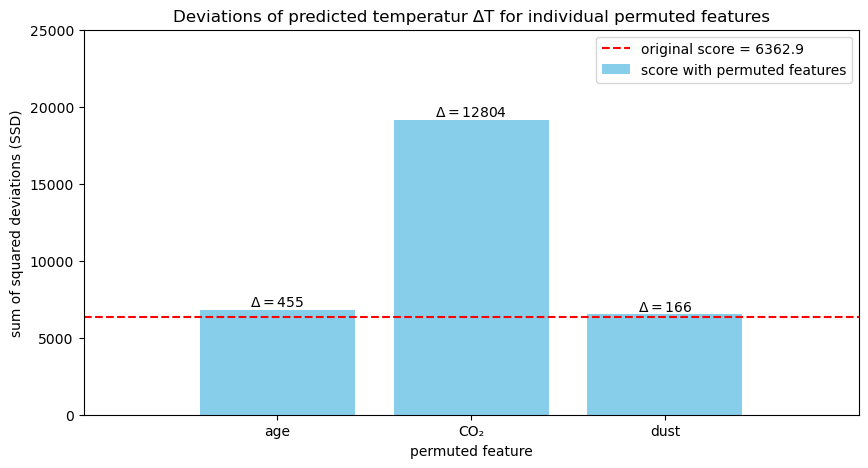

In [6]:
plt.figure(figsize=(10,5))
plt.title('Deviations of predicted temperatur ∆T for individual permuted features')
bar = plt.bar([0,1,2], ssds, color='skyblue', label='score with permuted features')
plt.plot([-1,3], np.ones(2)*original, 'r--', label=r'original score = '+str(round(original, 1)))
for rect in bar:
    delta = rect.get_height() - original
    plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), f'$\Delta={delta:.0f}$', ha='center', va='bottom')

plt.xticks([0,1,2], feature_names)
plt.xlabel('permuted feature')
plt.xlim(-1, 3)
plt.ylabel('sum of squared deviations (SSD)')
plt.ylim(0, 25000)
plt.legend()
plt.show()

The resulting sum of squared deviation scores are plotted as a bar chart. The red line marks the original ssd score.

The deviation is strongest for the permuted CO₂ feature, which suggests that it has the highest relevance for predicting the temperature ∆T.

The score is slightly increased for the age feature, and there is almost no difference for the dust feature, which therefore appears to be the least relevant.

## 3 σ² Estimation and Heteroscedastic Noise

### (a) Maximum Likelihood.
Focusing on a single point $(y_n, x_n)$ our linear regression model simplifies to

$$ y_n = β^T x_n + \varepsilon_n .$$

If we assume that $\varepsilon_n ∼ \mathcal{N}(0, \sigma^2)$, this is equivalent to the assumption that $y_n ∼ \mathcal{N} (\beta^T x_n, \sigma^2 )$. The logarithm of $p(y_n | \beta, \sigma^2)$ is known as the log-likelihood. Having observed $N$ data points this formulation generalizes to a sum of log-likelihoods and we can learn $\beta$ by maximizing the logarithm of

$$ \hat\beta = \arg\max_{\beta} \sum_{n=1}^N \log \mathcal{N}\left(y_n | \beta^Tx, \sigma^2 \right) .$$

Show that we are solving the same objective as in the SSQ formulation (just with a different scaling
factor) and get the same solution for β. This formulation is known as the Maximum Likelihood
approach, as we learn the parameters that maximize the likelihood of the data.

The SSQ formulation is: $$ \hat\beta = \arg\min_\beta \mathrm{SSQ} = \arg\min_\beta \sum_{n=1}^N \| y_n - \beta^T x_n\|^2 $$

For the maximum-(log-) likelihood fomulation, we first insert the conditional normal distribution:

$$ \hat\beta = \arg\max_\beta \sum_{n=1}^N \log \left[ \frac{1}{\sqrt{2\pi}\sigma^2} \exp ~ \left( -\frac{1}{2\sigma^2} (y_n - \beta^Tx )^2 \right) \right] $$

$$ = \arg\max_\beta \sum_{n=1}^N \log \left[ \frac{1}{\sqrt{2\pi}\sigma^2}\right] - \left[\frac{1}{2\sigma^2} (y_n - \beta^Tx )^2 \right] $$

$$ = \arg\max_\beta \sum_{n=1}^N \log \left[ \frac{1}{\sqrt{2\pi}\sigma^2}\right] - \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (y_n - \beta^Tx )^2 \right] $$

$$ = \arg\max_\beta N \log \left[ \frac{1}{\sqrt{2\pi}\sigma^2}\right] - \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (y_n - \beta^Tx )^2 \right] $$

We can ignore / remove the added constant $N \log(...)$ since it does not depend on $\beta$ and therefore has no influence on the $\arg\max$.

Flipping the minus sign changes $\arg\max$ to $\arg\min$:

$$ \hat\beta = \arg\min_\beta \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (y_n - \beta^Tx )^2 \right] $$

$$ = \arg\min_\beta \frac{1}{2\sigma^2} \sum_{n=1}^N \| y_n - \beta^Tx \|^2 = \arg\min_\beta \mathrm{SSQ}$$

The result is equal to the SSQ formulation except for the scaling factor $\frac{1}{2\sigma^2}$.

### (b) Estimation of σ².
Estimating $σ^2$ then analogously consists of finding the $\hat\sigma^2$ that maximizes this log-likelihood given the estimates $\hat\beta$, i.e.

$$ \hat\sigma^2 = \arg\max_{\sigma^2} \sum_{n=1}^N \log \mathcal{N}\left(y_n | \beta^Tx, \sigma^2 \right) .$$

Solve this and relate the result to the SSQ residual formulation from the lecture.

### (c)
Bonus: Heteroscedastic Noise. The standard formulation of linear regression is of homoscedastic
noise, i.e. the variances of the observation noise is independent of x. A generalization is to have a data
point dependent variance on the observation noise, i.e. we have

$$ y_n = \beta^T x_n + \varepsilon_n $$

with $\mathbb{E} [\varepsilon_n] = 0$ and $\mathrm{var}[\varepsilon_n ] = \sigma_n^2$ , which is known as heteroscedastic noise. Give the sum-of-squares problem in that case and derive mean and covariance structure of the $\hat\beta$ in that case.

## 4 Visualize Regularization Contours

In [7]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'{x.shape} {y.shape}')

(2, 100) (1, 100)


In [8]:
# TODO: create a grid of points in the parameter space
beta_i = np.linspace(-1, 3, 500)
betagrid = np.array(np.meshgrid(beta_i, beta_i))

### (a)
Plot the Ridge regression regularization term as well as the Lasso regularization term for $\beta_1 , \beta_2 \in [−1, 3]$.

Ridge regression uses L_2 as regularization term: $\| \beta \|_2^2$

Lasso regression used L_1 as regularization term: $\| \beta \|_1$

In [9]:
def ridge_regterm(b1, b2):
    return b1**2 + b2**2

def lasso_regterm(b1, b2):
    return np.abs(b1) + np.abs(b2)

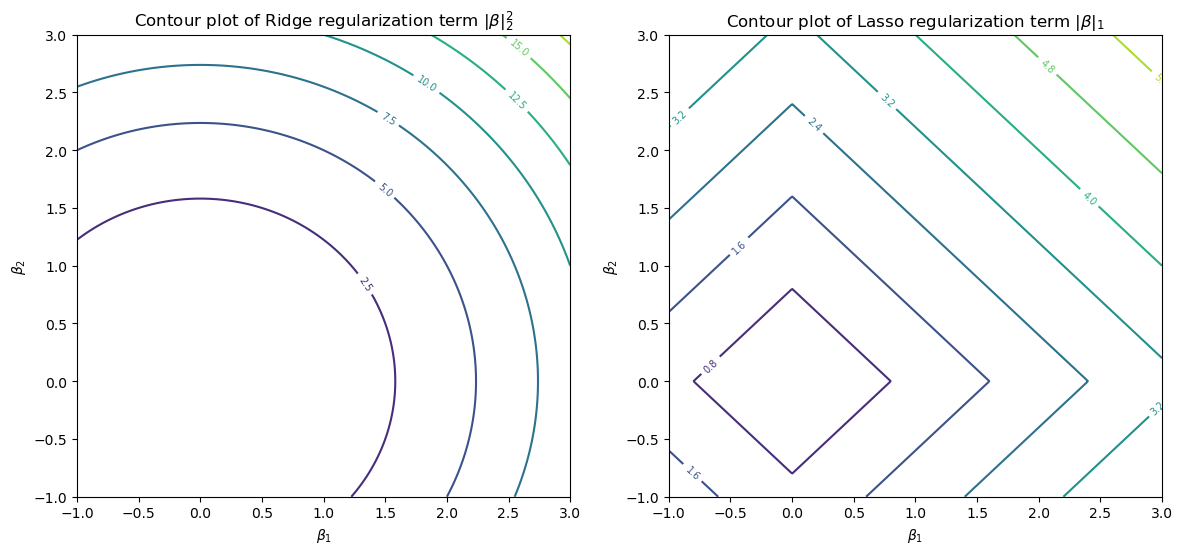

In [10]:
# TODO: make coutour plots for ridge and lasso regularization terms
fig, ax = plt.subplots(1,2, figsize=(14,6))
beta1, beta2 = betagrid

ax[0].set_title(r'Contour plot of Ridge regularization term $\| \beta \|_2^2$')
ridge = ax[0].contour(beta1, beta2, ridge_regterm(beta1, beta2))
ax[0].clabel(ridge, inline=True, fontsize=7)
ax[0].set_xlabel(r'$\beta_1$')
ax[0].set_ylabel(r'$\beta_2$')

ax[1].set_title(r'Contour plot of Lasso regularization term $\| \beta \|_1$')
lasso = ax[1].contour(beta1, beta2, lasso_regterm(beta1, beta2))
ax[1].clabel(lasso, inline=True, fontsize=7)
ax[1].set_xlabel(r'$\beta_1$')
ax[1].set_ylabel(r'$\beta_2$')
plt.show()

### (b)
For the data set linreg.npz plot the sum of squares (SSQ) of a linear regression as a function of $\beta$
over the same range as in (a), i.e. over the grid $[−1, 3] \times [−1, 3]$.

In [11]:
print(x.shape)
print(y.shape)

(2, 100)
(1, 100)


In [12]:
# TODO: for each combination of parameters, compute the sum of squared deviations.
#       do not use loops, but numpy broadcasting!
# TODO: make a coutour plot for sum of squared deviations

# intuitive solution using one loop:
lypred = np.array([beta1 * x[0][n] +  beta2 * x[1][n] for n in range(x.shape[1])])
lssq = np.sum((lypred - np.expand_dims(y.T, axis=1))**2, axis=0)
# we used this to verify the implementation below

In [13]:
# We use the dot product to compute \beta^T X
# To match shapes, we need to transpose. Remember this for later
print(f'{betagrid.shape = }')
ypred = np.dot(np.array(betagrid).T, x)
print(ypred.shape)

betagrid.shape = (2, 500, 500)
(500, 500, 100)


In [14]:
# just to visualize that broadcasting works out here
(ypred - y).shape

(500, 500, 100)

In [15]:
# calculate sum of squared errors
ssq = np.sum((ypred - y)**2, axis=2).T

In [16]:
# We run the linear regression and return the optimal parameters to see if our plot makes sense
betaopt = LinearRegression().fit(x.T, y.T).coef_[0]

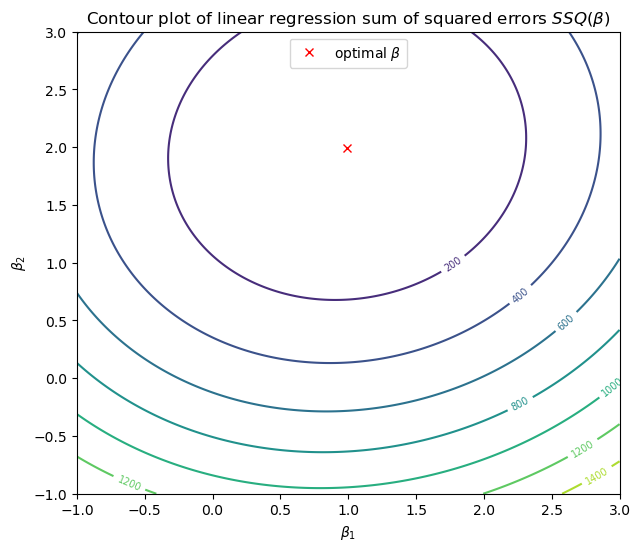

In [17]:
plt.figure(figsize=(7,6))
ax = plt.gca()
ax.set_title(r'Contour plot of linear regression sum of squared errors $SSQ(\beta)$')
contours = ax.contour(beta1, beta2, ssq)
ax.clabel(contours, inline=True, fontsize=7)
plt.plot(*betaopt, 'r x', label=r'optimal $\beta$')
ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\beta_2$')
plt.legend(loc='upper center')
plt.show()

In [18]:
for i, b in enumerate(betaopt):
    print('beta'+str(i), b)

beta0 0.9912379503154678
beta1 1.9922619503237609


We mark the position of the optimal parameter set $\beta$ obtained by linear regression (red x). It agrees well with the plotted contours

### (c)
Plot the ridge and Lasso loss functions, i.e. $\mathrm{SSQ}(\beta) + \lambda \|β\|_2^2$ and $\mathrm{SSQ}(\beta) + \lambda \|β\|_1$, for $\lambda \in {0, 10, 50, 100, 200, 300}$ in the same $\beta$ grid as before and discuss your observations!

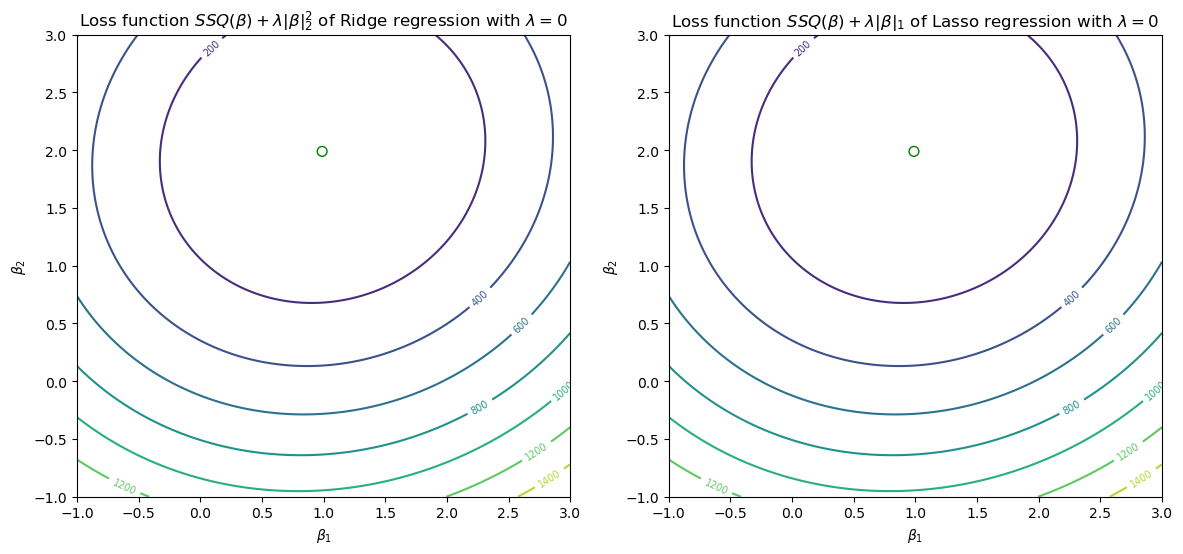

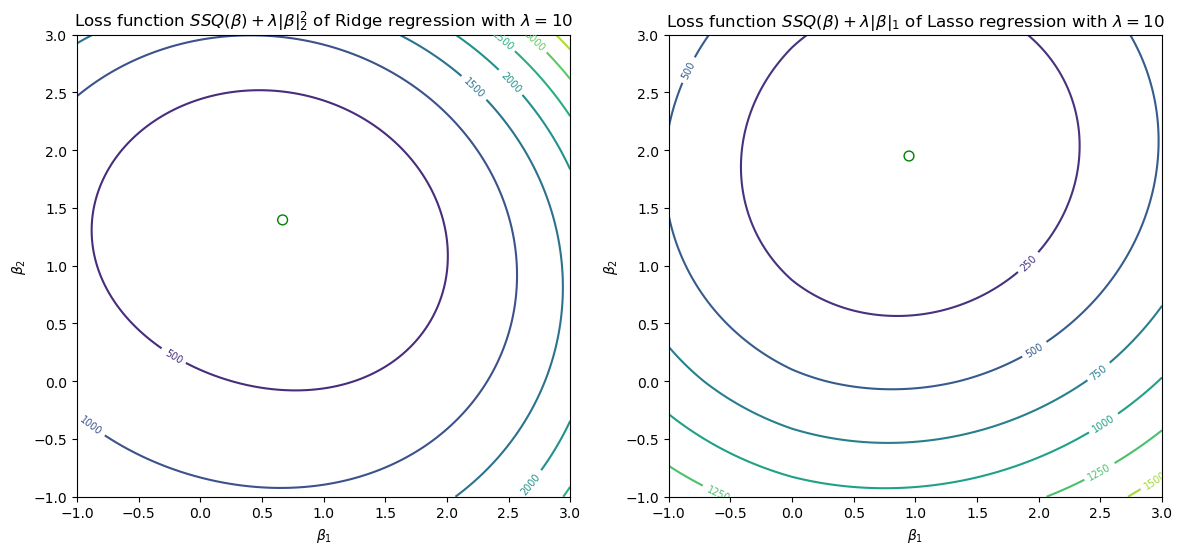

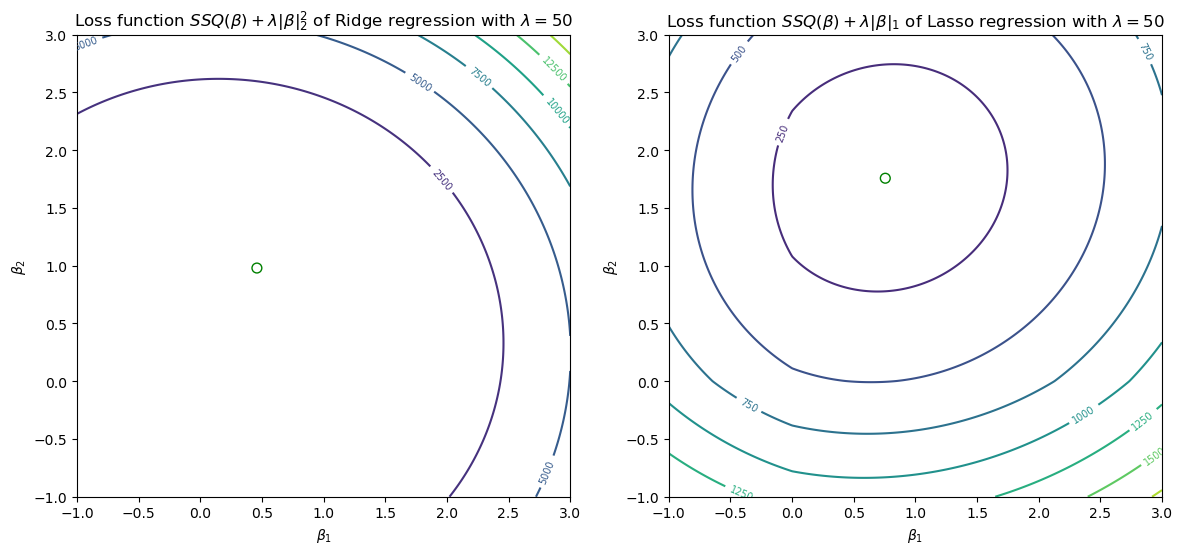

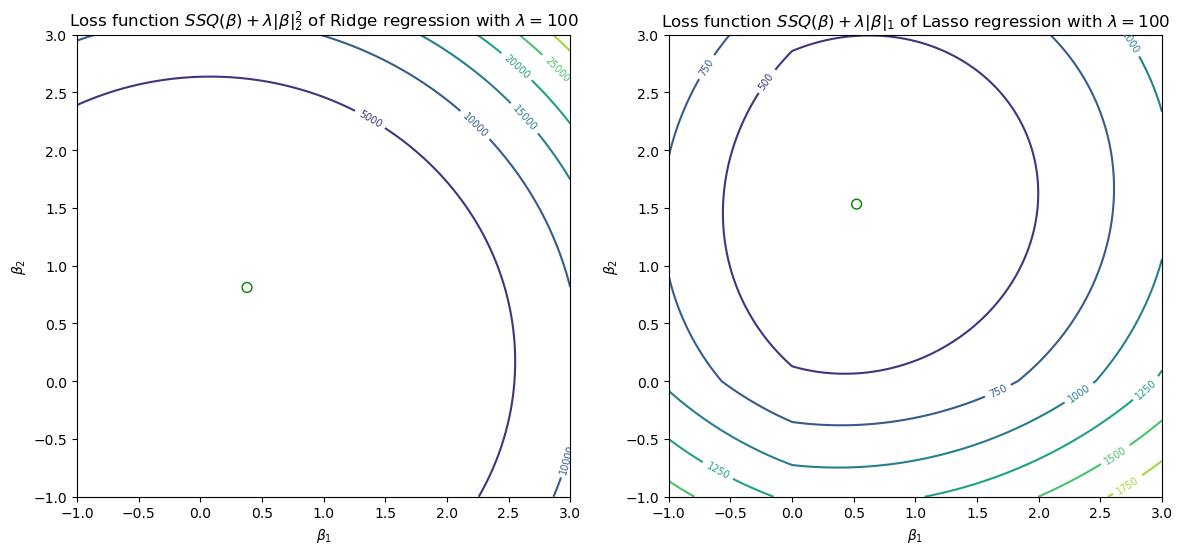

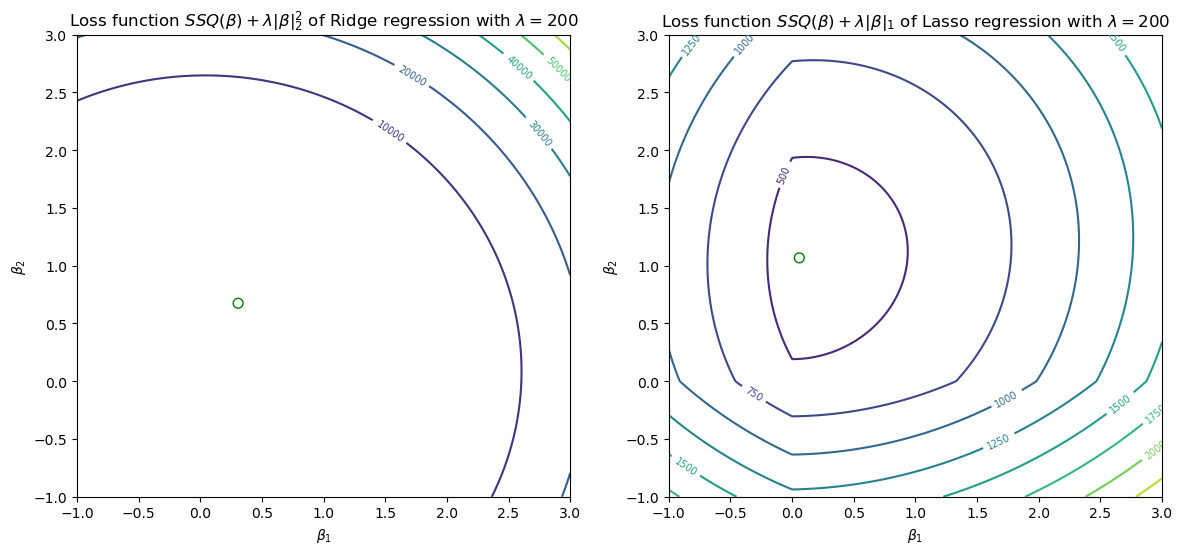

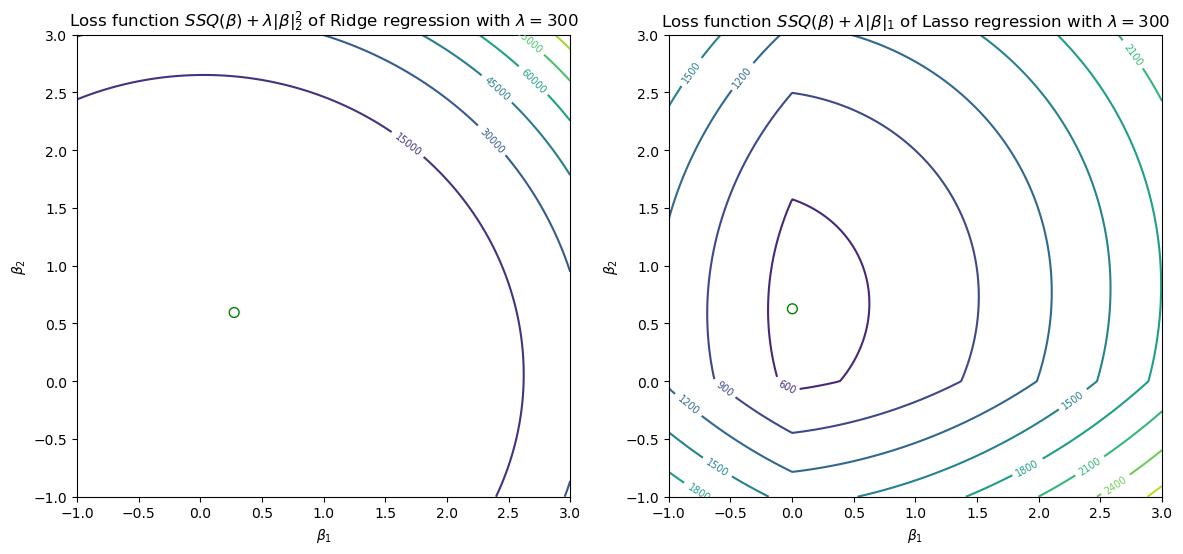

In [19]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]

for l in lambdas:

    fig, ax = plt.subplots(1,2, figsize=(14,6))
    beta0, beta1 = betagrid

    ax[0].set_title(r'Loss function $SSQ(\beta) + \lambda \| \beta \|_2^2$ of Ridge regression with $\lambda='+str(l)+'$')
    ridloss = ssq + l * ridge_regterm(beta0, beta1)
    mini = np.unravel_index(ridloss.argmin(), ridloss.shape)
    ridge = ax[0].contour(beta0, beta1, ridloss)
    ax[0].clabel(ridge, inline=True, fontsize=7)
    ax[0].scatter(beta_i[mini[1]], beta_i[mini[0]], s=50, facecolors='none', edgecolors='g', label=r'minimum')
    ax[0].set_xlabel(r'$\beta_1$')
    ax[0].set_ylabel(r'$\beta_2$')

    ax[1].set_title(r'Loss function $SSQ(\beta) + \lambda \| \beta \|_1$ of Lasso regression with $\lambda='+str(l)+'$')
    lassoloss = ssq + l * lasso_regterm(beta0, beta1)
    mini = np.unravel_index(lassoloss.argmin(), lassoloss.shape)
    lasso = ax[1].contour(beta0, beta1, lassoloss)
    ax[1].clabel(lasso, inline=True, fontsize=7)
    ax[1].scatter(beta_i[mini[1]], beta_i[mini[0]], s=50, facecolors='none', edgecolors='g', label=r'minimum')
    ax[1].set_xlabel(r'$\beta_1$')
    ax[1].set_ylabel(r'$\beta_2$')
    plt.show()

We mark the minimum of the loss function with a green circle.

For $\lambda=0$ both regression methods are identical to linear registration without regularization (loss function $=SSQ(\beta)$).

With increasing $\lambda$ the contours get "reshaped" into regularization contours. For Ridge regression they stay circular since the regularization term itself appears circular, while for Lasso regression, they develop corners.

The minimum gets drawn towards zero as the regularization term dominates. This effect is stronger / happens earlier for (quadratic) Ridge regression than for Lasso regression.

The minimum start to visually deviate from the SSQ-only result from $\lambda=50-100$ onwards.

## 5 CT Reconstruction

set up design matrix (run this once to save to disk)

In [20]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

if not os.path.exists('data/design_matrix.npy'):
    res = (99, 117)
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 #np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    n_parallel_rays = 70 
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_ray_angles = 30
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles
    
    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    def rot_mat(angle):
        c, s = np.cos(angle), np.sin(angle)
        return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    kernel = lambda x: np.exp(-x**2/sigma**2/2)

    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

created and saved design matrix of shape (11583, 2100) at data/design_matrix.npy


One application of linear regression is the reconstruction of CT-Scans. In this task, you will do this on simulated data in the 2D case. You are given a sinogram $Y \in \mathbb{R}^{ar}$ , a matrix where each row corresponds to a (1D) projection of the image consisting of $r$ detector readouts along one of a distinct, evenly spaced angles. Additionally, you are given the design matrix $X \in \mathbb{R}^{p\times ar}$. Excluding noise, one has $Y = IX$, with the image $I \in \mathbb{R}^{p}$ which should be reconstructed.

Some facts/descriptions for our understanding:

Each 1D projection consists $r$ detector pixel readouts, and there are $a$ different, evenly-spaced projection angles.

Rows of the sinogram $Y \in \mathbb{R}^{ar}$ are projections. Columns are the readout value of one pixel over all the angles.

### (a)
What is the interpretation of a column of $X$? Visualize a choice of four columns as images.

In [21]:
design_matrix = np.load('data/design_matrix.npy')
sino = np.load('data/sino.npy')

print(f'{design_matrix.shape=}')
print(f'{sino.shape=}')

design_matrix.shape=(11583, 2100)
sino.shape=(1, 2100)


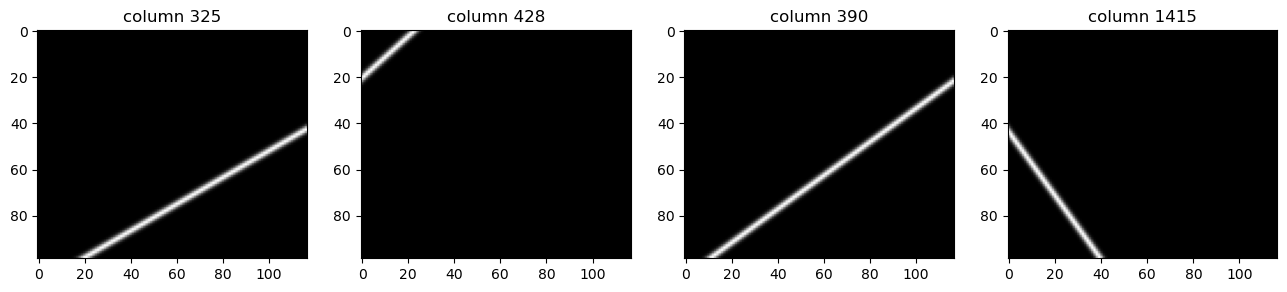

In [22]:
# TODO: visualize four random columns as images, using an image shape of (99, 117)
img_shape = (99, 117)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in zip(np.random.choice(np.arange(design_matrix.shape[1]), 4), axs):
    # since the images visualize the rays / the direction, we leave interpolation on
    ax.imshow(design_matrix[:, i].reshape(*img_shape), cmap='gray');
    ax.set_title(f'column {i}')

For the design matrix $X \in \mathbb{R}^{p\times ar}$:

The rows are the $99 \times 117 = 11583$ pixels of the resulting image.

The **columns** correspond to the individual x-rays pasing through the object at different angles and different detector positions: <br> $70$ parallel detector readouts $\times$ $30$ angles $= 2100$ rays.

The matrix describes how much each x-ray intersects with each of the pixels.

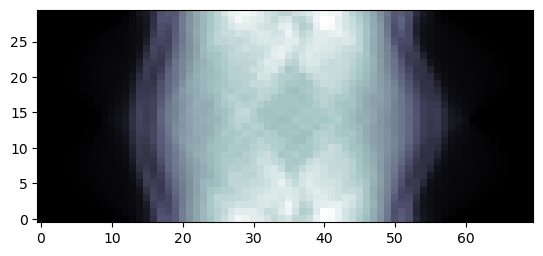

In [23]:
# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower', cmap='bone', interpolation='none')
plt.show();

### (b)
Solve the reconstruction problem with linear regression without any regularization and with ridge regression. What do you observe?

The reconstruction problem is given by:
$$ Y = \beta^T X $$

Where $Y$ is the sinogram, $\beta$ is the wanted array of pixels (the image) and $X$ is the design matrix.

We obtain $\beta$ by performing `from sklearn.linear_model.LinearRegression` and returning the parameters/coefficients.

In [24]:
# TODO: solve the reconstruction with linear regression and visualize the result
linreg = LinearRegression(copy_X=True)
linreg.fit(sino.T, design_matrix.T)

# TODO: solve the reconstruction with ridge regression and visualize the result
ridreg = Ridge(copy_X=True)
ridreg.fit(sino.T, design_matrix.T)

linimg = linreg.coef_.reshape(img_shape)
ridimg = ridreg.coef_.reshape(img_shape)
print(f'{linimg.shape = }\n{ridimg.shape = }')

linimg.shape = (99, 117)
ridimg.shape = (99, 117)


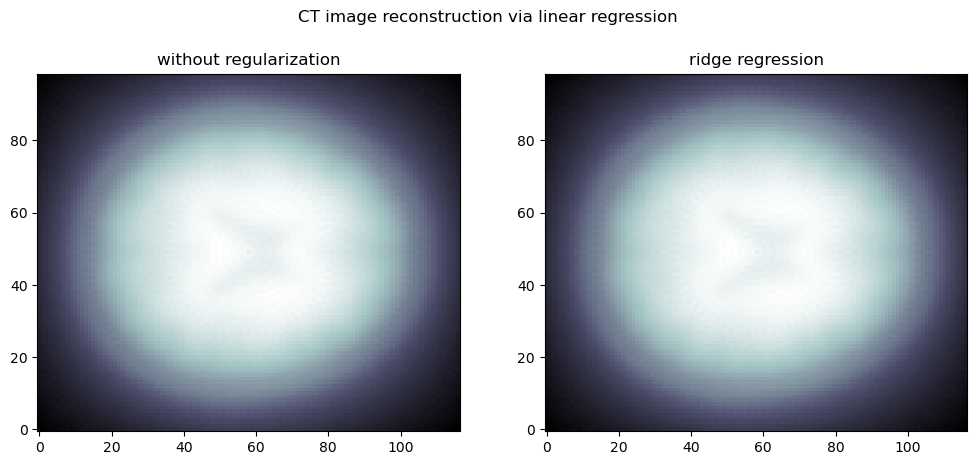

In [25]:
plt.subplots(1,2, figsize=(12,5))
plt.suptitle('CT image reconstruction via linear regression')

vmin, vmax = min(linimg.min(), ridimg.min()), max(linimg.max(), ridimg.max())
plt.subplot(1,2,1)
plt.title('without regularization')
plt.imshow(linimg, cmap='bone', origin='lower', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.title('ridge regression')
plt.imshow(ridimg, cmap='bone', origin='lower', vmin=vmin, vmax=vmax)
plt.show()

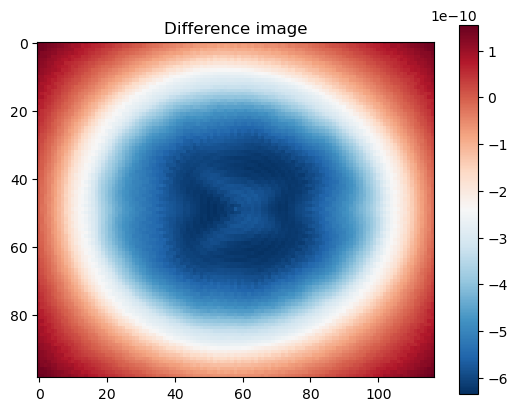

In [26]:
plt.title('Difference image')
plt.imshow(ridimg - linimg, cmap='RdBu_r')
plt.colorbar()
plt.show()

The image reconstructed with ridge regression (regularization) appears overall clearer. It is slightly more sharp/contrasted. The brain matter is more homogenous, while it show "over-exposed" towards the center in the un-regularized image.

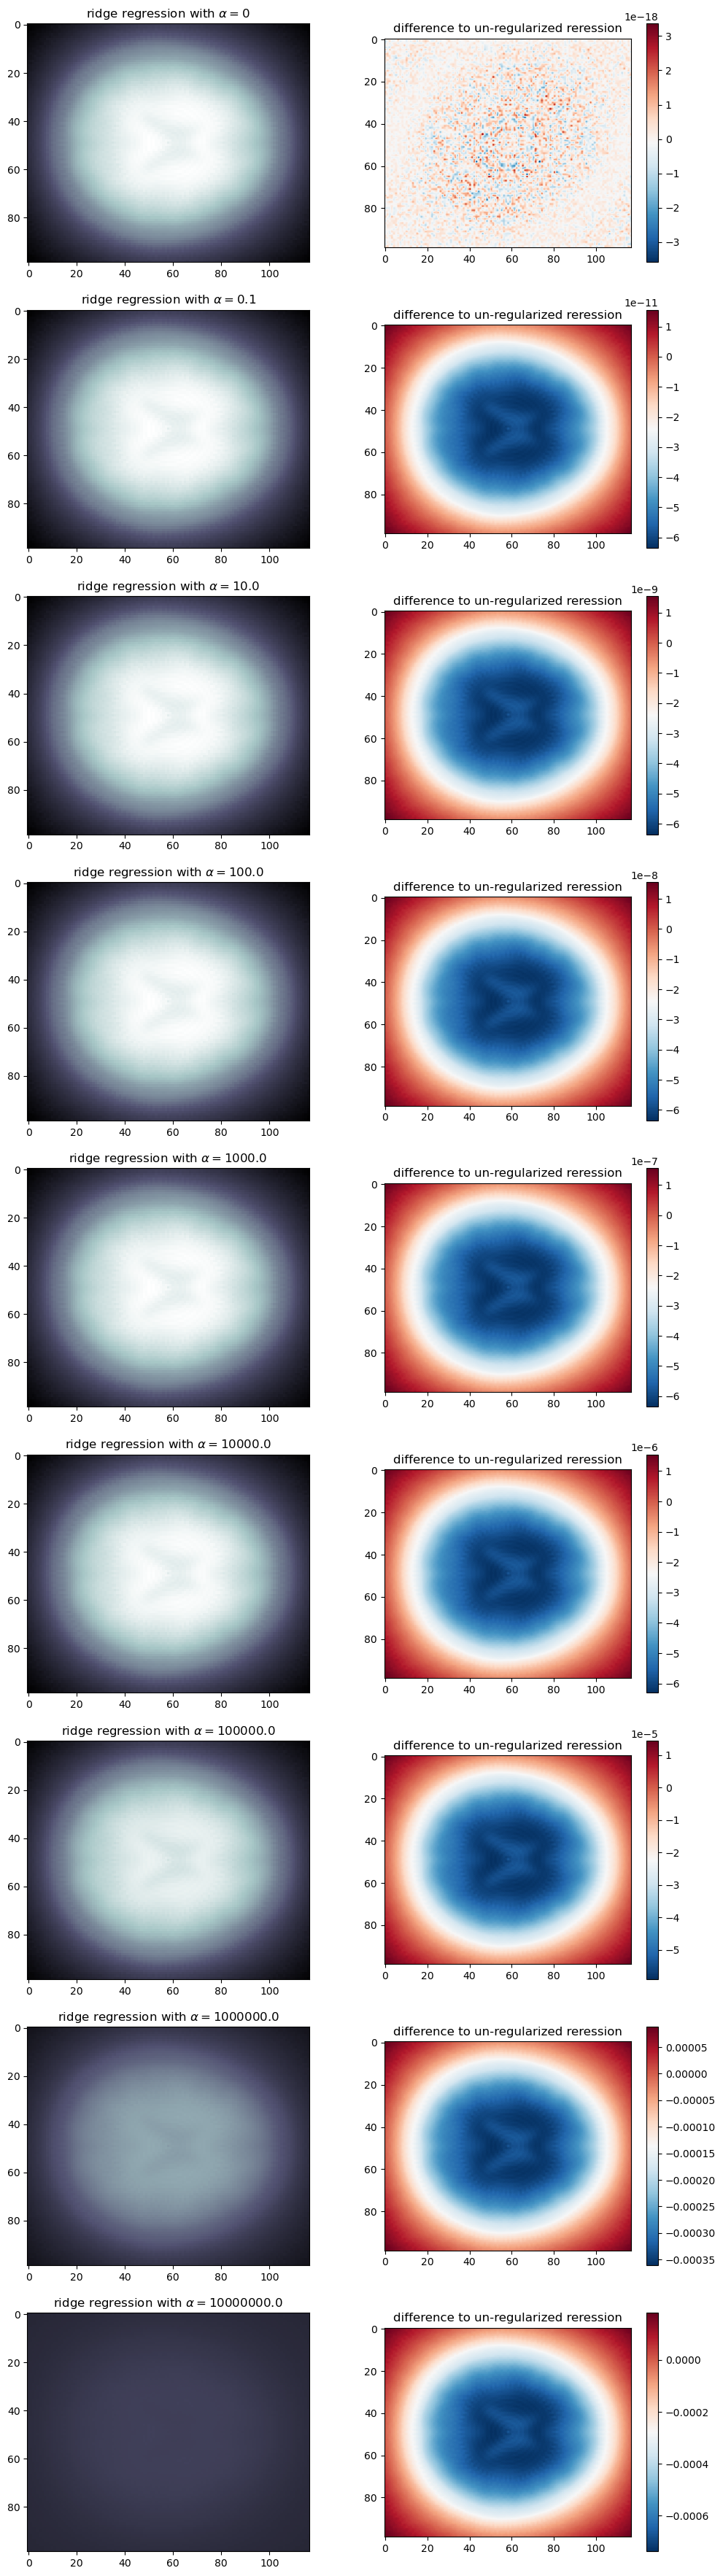

In [27]:
# Optional: try out different regularization strengths and oberve the influence
alphas = [0, 1E-1, 1E+1, 1E+2, 1E+3, 1E+4, 1E+5, 1E+6, 1E+7]

plt.subplots(len(alphas), 2, figsize=(12,5*len(alphas)))

for i,a in enumerate(alphas):
    ridreg = Ridge(copy_X=True, alpha=a)
    ridreg.fit(sino.T, design_matrix.T)
    ridimg = ridreg.coef_.reshape(img_shape)
    diffimg = ridimg - linimg

    vmin, vmax = min(linimg.min(), ridimg.min()), max(linimg.max(), ridimg.max())
    plt.subplot(len(alphas), 2, i*2+1)
    plt.title(r'ridge regression with $\alpha = '+str(round(a,1))+'$')
    plt.imshow(ridimg, cmap='bone', vmin=vmin, vmax=vmax)
    plt.subplot(len(alphas), 2, i*2+2)
    plt.title('difference to un-regularized reression')
    plt.imshow(diffimg, cmap='RdBu_r')#, vmin=vmin*1E-5, vmax=vmax*1E-5)
    plt.colorbar()
    
plt.show()

Except for numerical errors, the case of regularization strength $\alpha = 0$ is identical to un-regularized linear regression, which is expected.

With increasing regularization, the image first becomes sharper, but then looses contrast (begins to "fade") for very high values of $\alpha$. This is also expected, since at some point the regularization therm dominates the loss, forbids optimization by forcing the parameters $\beta$ to zero and thereby creates a black (zero-only) image.

## 6 Bonus: X-Ray Free-Electron Lasers

Imagine the reconstruction problem from task 5, but without the knowledge about which detections correspond to which orientations of the sample. This scenario actually happens in the analysis of X-ray free-electron laser data: The laser is aimed at a sample (a tiny protein crystal), and the diffraction pattern of a short high-energy pulse is recorded. This is repeated many times, but never is the orientation of the sample known. Nevertheless, it’s possible to reconstruct the structure of proteins from such data. How would you approach this problem? Try to reconstruct the image from the data of task 5, after shuffling the sinogram along the angle axis.